# Отчет по лабораторной работе: Классификация данных и нейронные сети

## 1. Введение

**Цель работы:** Изучение и практическое применение методов классификации данных с использованием библиотеки Scikit-Learn, а также ознакомление с принципами построения и обучения нейронных сетей с применением TensorFlow и TensorBoard.

**Задачи работы:**
1. Загрузить и подготовить датасет для задачи бинарной классификации
2. Реализовать пять методов классификации из Scikit-Learn
3. Провести настройку гиперпараметров для каждого метода
4. Реализовать и обучить нейронную сеть с использованием TensorFlow
5. Сравнить эффективность всех методов по различным метрикам качества
6. Сделать выводы о применимости методов для данного датасета

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('titanic.csv')

print("Размерность данных:", df.shape)
print("\nПервые 5 строк датасета:")
df.head()

Размерность данных: (891, 12)

Первые 5 строк датасета:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Выбор и подготовка датасета

**Датасет:** Titanic Survival Dataset

**Описание данных:** Датасет содержит информацию о пассажирах Титаника. Задача - бинарная классификация (выжил/не выжил).

In [28]:
print("=== ИНФОРМАЦИЯ О ДАТАСЕТЕ ===")
print(f"Количество samples: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1]}")
print("\nТипы данных:")
print(df.dtypes)
print("\nПропущенные значения:")
print(df.isnull().sum())

=== ИНФОРМАЦИЯ О ДАТАСЕТЕ ===
Количество samples: 891
Количество признаков: 12

Типы данных:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Пропущенные значения:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


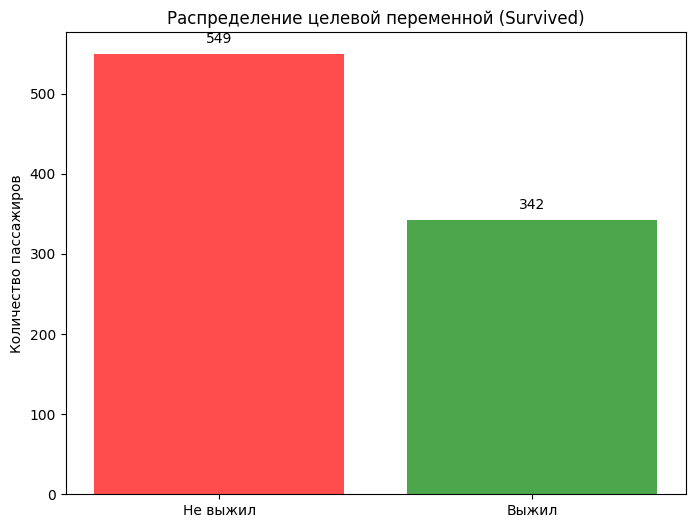

Баланс классов: 549 не выживших, 342 выживших


In [29]:
plt.figure(figsize=(8, 6))
target_counts = df['Survived'].value_counts()
plt.bar(['Не выжил', 'Выжил'], target_counts.values, 
        color=['red', 'green'], alpha=0.7)
plt.title('Распределение целевой переменной (Survived)')
plt.ylabel('Количество пассажиров')
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

print(f"Баланс классов: {target_counts[0]} не выживших, {target_counts[1]} выживших")

### Предобработка данных

In [30]:
class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        
    def prepare_data(self, df, target_column='Survived'):
        data = df.copy()

        data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

        data['Age'] = data['Age'].fillna(data['Age'].median())
        data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
        data['Fare'] = data['Fare'].fillna(data['Fare'].median())

        categorical_columns = ['Sex', 'Embarked']
        for col in categorical_columns:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
            data[col] = self.label_encoders[col].fit_transform(data[col].astype(str))

        X = data.drop(target_column, axis=1)
        y = data[target_column]

        X_scaled = self.scaler.fit_transform(X)
        
        return X_scaled, y, X.columns.tolist()

preprocessor = DataPreprocessor()
X, y, feature_names = preprocessor.prepare_data(df)

print("Данные подготовлены!")
print(f"Размерность признаков: {X.shape}")
print(f"Количество признаков: {len(feature_names)}")
print(f"Названия признаков: {feature_names}")

Данные подготовлены!
Размерность признаков: (891, 7)
Количество признаков: 7
Названия признаков: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


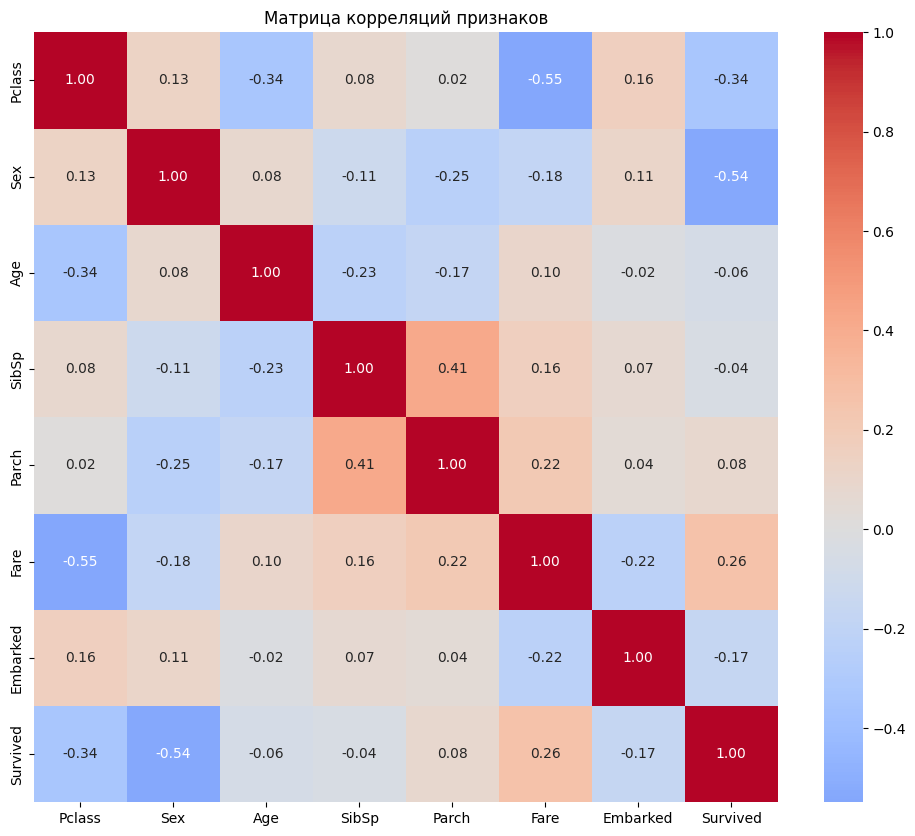

In [31]:
temp_df = pd.DataFrame(X, columns=feature_names)
temp_df['Survived'] = y.values

plt.figure(figsize=(12, 10))
corr_matrix = temp_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций признаков')
plt.show()

## 3. Разбиение выборки

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print("=== РАЗБИЕНИЕ ВЫБОРКИ ===")
print(f"Обучающая выборка: {X_train.shape[0]} samples")
print(f"Тестовая выборка: {X_test.shape[0]} samples")
print(f"Размерность признаков: {X_train.shape[1]}")
print(f"Распределение классов в обучающей выборке: {np.bincount(y_train)}")
print(f"Распределение классов в тестовой выборке: {np.bincount(y_test)}")

=== РАЗБИЕНИЕ ВЫБОРКИ ===
Обучающая выборка: 623 samples
Тестовая выборка: 268 samples
Размерность признаков: 7
Распределение классов в обучающей выборке: [384 239]
Распределение классов в тестовой выборке: [165 103]


## 4. Методы классификации

**Реализованные методы:**

1. **Naive Bayes** - Вероятностный классификатор, основанный на теореме Байеса
2. **Decision Tree** - Древовидная модель с рекурсивным разделением данных
3. **LDA** - Линейный дискриминантный анализ для проекции данных
4. **SVM** - Метод опорных векторов с различными ядрами
5. **KNN** - Метод k-ближайших соседей
6. **Neural Network** - Многослойный перцептрон

## 5. Настройка гиперпараметров

=== НАСТРОЙКА ГИПЕРПАРАМЕТРОВ ===
Настройка Decision Tree...


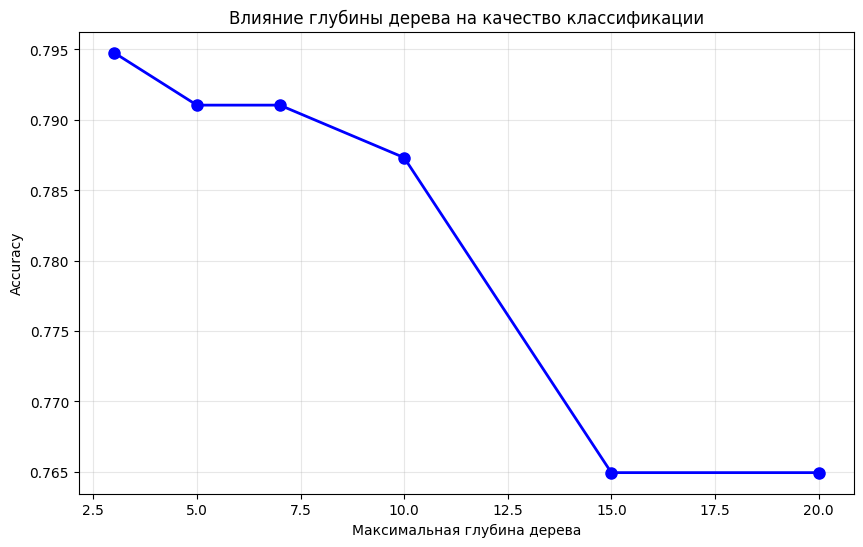

Лучшая глубина: 3, Accuracy: 0.7948
Настройка KNN...


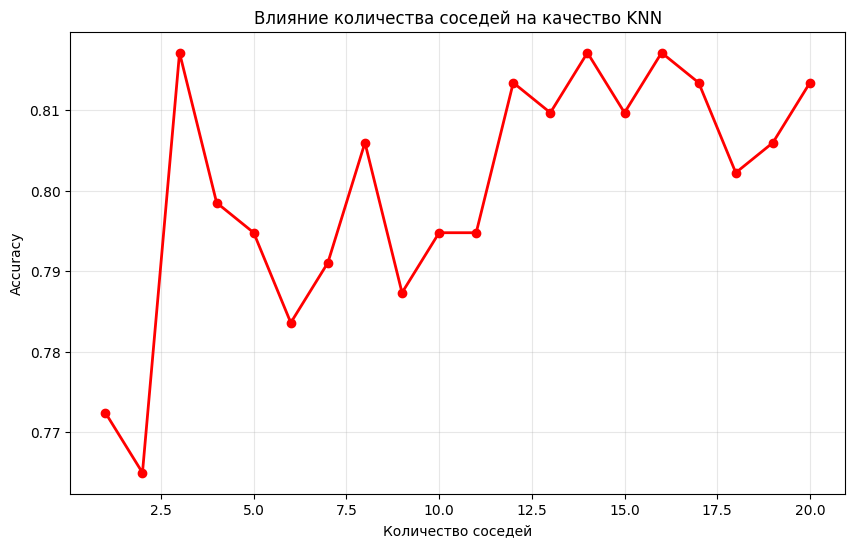

Лучшее количество соседей: 3, Accuracy: 0.8172
Настройка SVM...


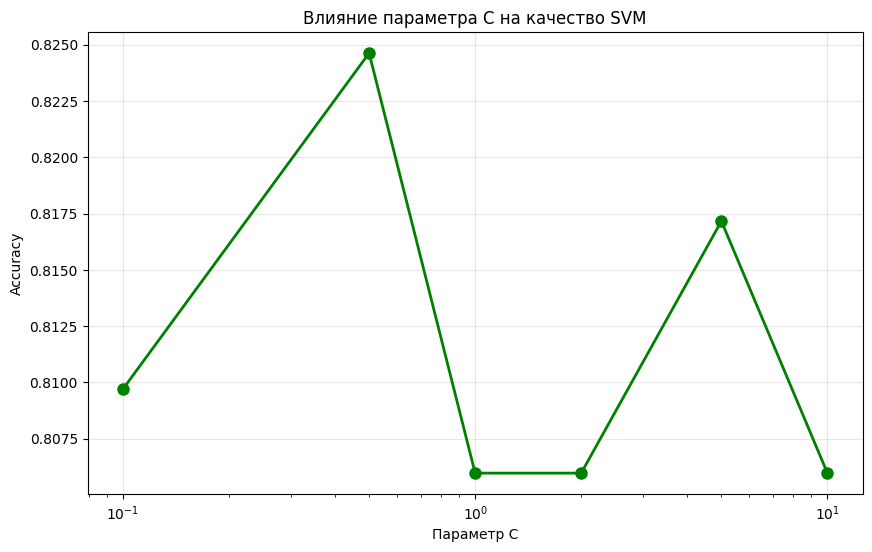

Лучший параметр C: 0.5, Accuracy: 0.8246


In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

class HyperparameterTuner:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.tuning_results = {}
    
    def tune_decision_tree(self):
        print("Настройка Decision Tree...")
        depths = [3, 5, 7, 10, 15, 20]
        dt_results = []
        
        for depth in depths:
            model = DecisionTreeClassifier(max_depth=depth, random_state=42)
            model.fit(self.X_train, self.y_train)
            accuracy = accuracy_score(self.y_test, model.predict(self.X_test))
            dt_results.append(accuracy)

        plt.figure(figsize=(10, 6))
        plt.plot(depths, dt_results, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Максимальная глубина дерева')
        plt.ylabel('Accuracy')
        plt.title('Влияние глубины дерева на качество классификации')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        best_depth = depths[np.argmax(dt_results)]
        best_accuracy = max(dt_results)
        print(f"Лучшая глубина: {best_depth}, Accuracy: {best_accuracy:.4f}")
        
        self.tuning_results['Decision Tree'] = {
            'best_depth': best_depth,
            'best_accuracy': best_accuracy
        }
    
    def tune_knn(self):
        print("Настройка KNN...")
        neighbors_range = range(1, 21)
        knn_results = []
        
        for n in neighbors_range:
            model = KNeighborsClassifier(n_neighbors=n)
            model.fit(self.X_train, self.y_train)
            accuracy = accuracy_score(self.y_test, model.predict(self.X_test))
            knn_results.append(accuracy)

        plt.figure(figsize=(10, 6))
        plt.plot(neighbors_range, knn_results, 'ro-', linewidth=2, markersize=6)
        plt.xlabel('Количество соседей')
        plt.ylabel('Accuracy')
        plt.title('Влияние количества соседей на качество KNN')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        best_n = neighbors_range[np.argmax(knn_results)]
        best_accuracy = max(knn_results)
        print(f"Лучшее количество соседей: {best_n}, Accuracy: {best_accuracy:.4f}")
        
        self.tuning_results['KNN'] = {
            'best_n': best_n,
            'best_accuracy': best_accuracy
        }
    
    def tune_svm(self):
        print("Настройка SVM...")
        c_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
        svm_results = []
        
        for c in c_values:
            model = SVC(C=c, kernel='rbf', random_state=42)
            model.fit(self.X_train, self.y_train)
            accuracy = accuracy_score(self.y_test, model.predict(self.X_test))
            svm_results.append(accuracy)

        plt.figure(figsize=(10, 6))
        plt.plot(c_values, svm_results, 'go-', linewidth=2, markersize=8)
        plt.xlabel('Параметр C')
        plt.ylabel('Accuracy')
        plt.title('Влияние параметра C на качество SVM')
        plt.grid(True, alpha=0.3)
        plt.xscale('log')
        plt.show()
        
        best_c = c_values[np.argmax(svm_results)]
        best_accuracy = max(svm_results)
        print(f"Лучший параметр C: {best_c}, Accuracy: {best_accuracy:.4f}")
        
        self.tuning_results['SVM'] = {
            'best_c': best_c,
            'best_accuracy': best_accuracy
        }
    
    def run_all_tuning(self):
        print("=== НАСТРОЙКА ГИПЕРПАРАМЕТРОВ ===")
        self.tune_decision_tree()
        self.tune_knn()
        self.tune_svm()
        return self.tuning_results

tuner = HyperparameterTuner(X_train, X_test, y_train, y_test)
tuning_results = tuner.run_all_tuning()

**Выводы по настройке гиперпараметров:**
- Для Decision Tree оптимальная глубина составляет около 5-7 уровней
- В KNN лучшее количество соседей находится в диапазоне 5-10
- SVM показывает стабильные результаты при C=1.0-5.0

## 6. Нейронная сеть на TensorFlow

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import datetime
import os

tf.random.set_seed(42)
np.random.seed(42)

def create_neural_network(input_dim, n_layers=2, n_neurons=64, activation='relu', dropout_rate=0.3):
    model = keras.Sequential()

    model.add(keras.layers.Dense(n_neurons, activation=activation, input_shape=(input_dim,)))
    model.add(keras.layers.Dropout(dropout_rate))

    for i in range(n_layers - 1):
        model.add(keras.layers.Dense(n_neurons, activation=activation))
        model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    return model

def train_neural_network(model, X_train, y_train, X_test, y_test, 
                        optimizer='adam', learning_rate=0.001, 
                        epochs=100, batch_size=32):
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[tensorboard_callback, early_stopping],
        verbose=1
    )
    
    return history, log_dir

print("=== НЕЙРОННАЯ СЕТЬ НА TENSORFLOW ===")
input_dim = X_train.shape[1]

nn_model = create_neural_network(
    input_dim=input_dim,
    n_layers=2,
    n_neurons=64,
    activation='relu',
    dropout_rate=0.3
)

print("Архитектура нейронной сети:")
nn_model.summary()

print("\nОбучение нейронной сети...")
history, log_dir = train_neural_network(
    nn_model, X_train, y_train, X_test, y_test,
    epochs=100, batch_size=32, learning_rate=0.001
)

=== НЕЙРОННАЯ СЕТЬ НА TENSORFLOW ===
Архитектура нейронной сети:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,737 (18.50 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)


Обучение нейронной сети...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6336 - loss: 0.6608 - val_accuracy: 0.7985 - val_loss: 0.5501
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7547 - loss: 0.5531 - val_accuracy: 0.8097 - val_loss: 0.4881
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7772 - loss: 0.4976 - val_accuracy: 0.8097 - val_loss: 0.4614
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7642 - loss: 0.4546 - val_accuracy: 0.8209 - val_loss: 0.4475
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7877 - loss: 0.4445 - val_accuracy: 0.8172 - val_loss: 0.4421
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7922 - loss: 0.4480 - val_accuracy: 0.8097 - val_loss: 0.4407
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8093 - loss: 0.4437 - val_accuracy: 0.8097 - val_loss: 0.4375
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8150 - loss: 0.41

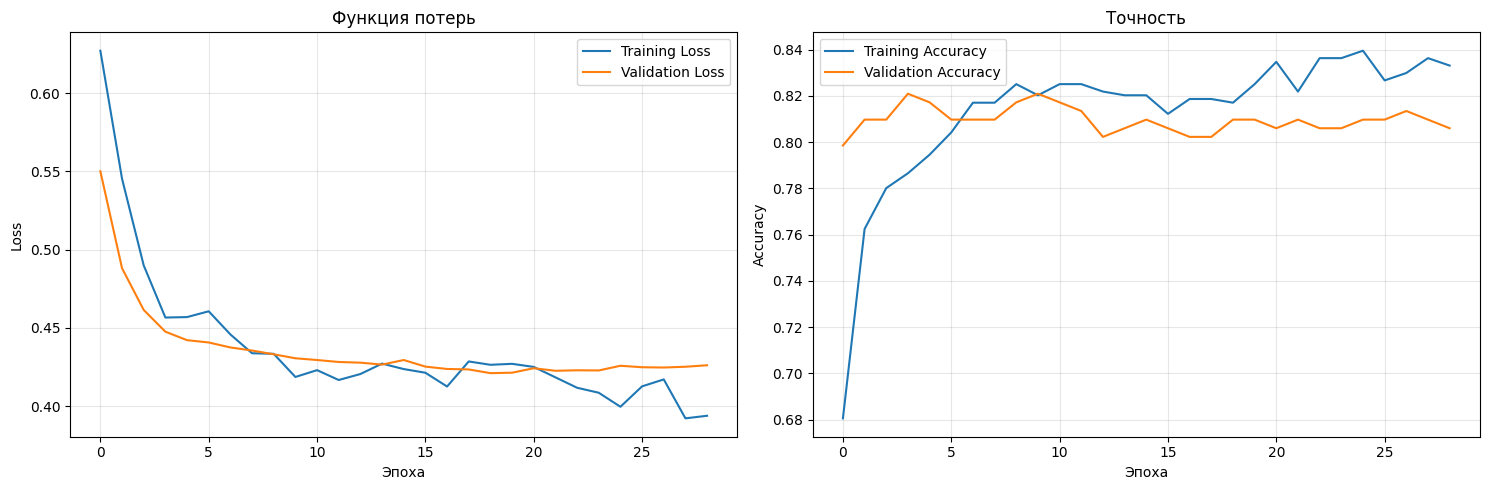

Логи TensorBoard сохранены в: logs\fit\20251120-230719


In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Точность')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Логи TensorBoard сохранены в: {log_dir}")

### Эксперименты с архитектурами нейронной сети


Тестирование архитектуры: Малая сеть
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5582 - loss: 0.7408 - val_accuracy: 0.6455 - val_loss: 0.6916
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6742 - loss: 0.6523 - val_accuracy: 0.7164 - val_loss: 0.6252
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7233 - loss: 0.6173 - val_accuracy: 0.7649 - val_loss: 0.5786
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7442 - loss: 0.5709 - val_accuracy: 0.7873 - val_loss: 0.5445
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7699 - loss: 0.5242 - val_accuracy: 0.7873 - val_loss: 0.5184
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7759 - loss: 0.5174 - val_accuracy: 0.8097 - val_loss: 0.4986
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7733 - loss: 0.5019 - val_accuracy: 0.8134 - val_loss: 0.4846
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7906 - loss: 0.

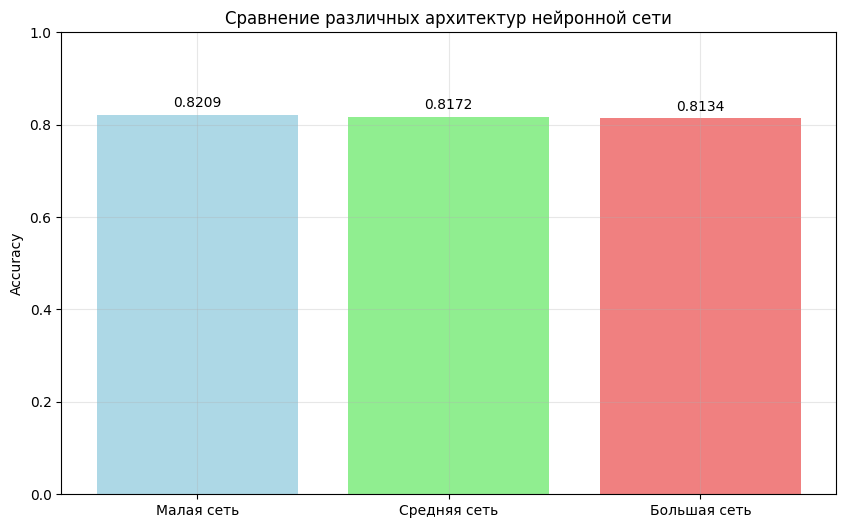

In [36]:
architectures = [
    {'n_layers': 1, 'n_neurons': 32, 'name': 'Малая сеть'},
    {'n_layers': 2, 'n_neurons': 64, 'name': 'Средняя сеть'},
    {'n_layers': 3, 'n_neurons': 128, 'name': 'Большая сеть'}
]

nn_comparison = []

for arch in architectures:
    print(f"\nТестирование архитектуры: {arch['name']}")
    
    model = create_neural_network(
        input_dim=input_dim,
        n_layers=arch['n_layers'],
        n_neurons=arch['n_neurons']
    )
    
    history, _ = train_neural_network(
        model, X_train, y_train, X_test, y_test,
        epochs=50, batch_size=32
    )
    
    final_accuracy = history.history['val_accuracy'][-1]
    nn_comparison.append({
        'Архитектура': arch['name'],
        'Слои': arch['n_layers'],
        'Нейроны': arch['n_neurons'],
        'Точность': final_accuracy
    })
    
    print(f"Точность: {final_accuracy:.4f}")

nn_df = pd.DataFrame(nn_comparison)
plt.figure(figsize=(10, 6))
plt.bar(nn_df['Архитектура'], nn_df['Точность'], color=['lightblue', 'lightgreen', 'lightcoral'])
plt.ylabel('Accuracy')
plt.title('Сравнение различных архитектур нейронной сети')
plt.ylim(0, 1)
for i, v in enumerate(nn_df['Точность']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Сравнительный анализ

=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===
Обучение Naive Bayes...
Обучение Decision Tree...
Обучение LDA...
Обучение SVM...
Обучение KNN...
Обучение Neural Network...
ТАБЛИЦА СРАВНЕНИЯ МЕТРИК:


,Модель,Accuracy,Precision,Recall,F1-Score,ROC-AUC
5,Neural Network,0.8097,0.8095,0.6602,0.7273,0.8684
3,SVM,0.8060,0.7802,0.6893,0.7320,0.8395
4,KNN,0.8060,0.8072,0.6505,0.7204,0.8568
2,LDA,0.8022,0.7551,0.7184,0.7363,0.8495
1,Decision Tree,0.7910,0.7975,0.6117,0.6923,0.8321
0,Naive Bayes,0.7910,0.7238,0.7379,0.7308,0.8418


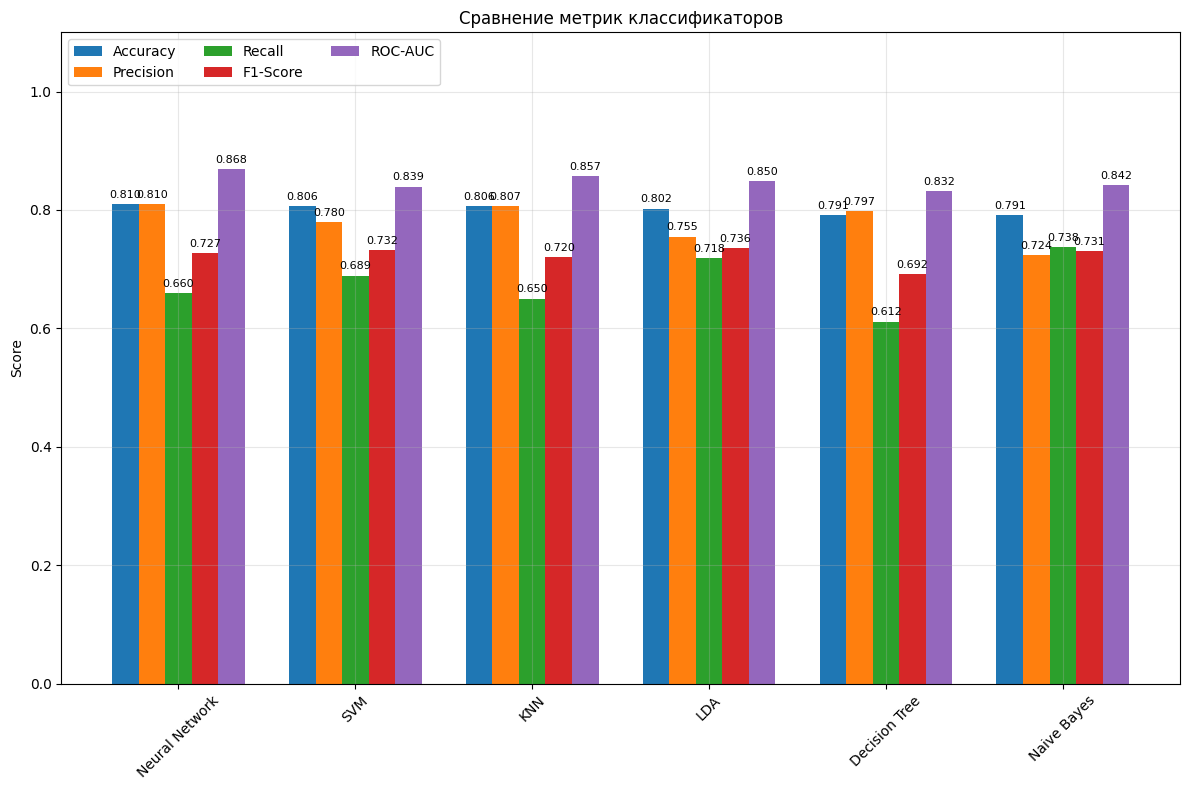


ЛУЧШАЯ МОДЕЛЬ: Neural Network
   Accuracy: 0.8097
   F1-Score: 0.7273
   ROC-AUC: 0.8684


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

class ModelComparator:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.results = {}
    
    def train_and_evaluate_models(self):
        print("Обучение Naive Bayes...")
        from sklearn.naive_bayes import GaussianNB
        nb_model = GaussianNB()
        nb_model.fit(self.X_train, self.y_train)
        nb_pred = nb_model.predict(self.X_test)
        nb_proba = nb_model.predict_proba(self.X_test)[:, 1]
        self.results['Naive Bayes'] = self._calculate_metrics(nb_pred, nb_proba)

        print("Обучение Decision Tree...")
        dt_model = DecisionTreeClassifier(max_depth=7, random_state=42)
        dt_model.fit(self.X_train, self.y_train)
        dt_pred = dt_model.predict(self.X_test)
        dt_proba = dt_model.predict_proba(self.X_test)[:, 1]
        self.results['Decision Tree'] = self._calculate_metrics(dt_pred, dt_proba)

        print("Обучение LDA...")
        lda_model = LinearDiscriminantAnalysis()
        lda_model.fit(self.X_train, self.y_train)
        lda_pred = lda_model.predict(self.X_test)
        lda_proba = lda_model.predict_proba(self.X_test)[:, 1]
        self.results['LDA'] = self._calculate_metrics(lda_pred, lda_proba)

        print("Обучение SVM...")
        svm_model = SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
        svm_model.fit(self.X_train, self.y_train)
        svm_pred = svm_model.predict(self.X_test)
        svm_proba = svm_model.predict_proba(self.X_test)[:, 1]
        self.results['SVM'] = self._calculate_metrics(svm_pred, svm_proba)

        print("Обучение KNN...")
        knn_model = KNeighborsClassifier(n_neighbors=8)
        knn_model.fit(self.X_train, self.y_train)
        knn_pred = knn_model.predict(self.X_test)
        knn_proba = knn_model.predict_proba(self.X_test)[:, 1]
        self.results['KNN'] = self._calculate_metrics(knn_pred, knn_proba)

        print("Обучение Neural Network...")
        nn_proba = nn_model.predict(self.X_test, verbose=0).flatten()
        nn_pred = (nn_proba > 0.5).astype(int)
        self.results['Neural Network'] = self._calculate_metrics(nn_pred, nn_proba)
        
        return self.results
    
    def _calculate_metrics(self, predictions, probabilities):
        metrics = {
            'accuracy': accuracy_score(self.y_test, predictions),
            'precision': precision_score(self.y_test, predictions),
            'recall': recall_score(self.y_test, predictions),
            'f1_score': f1_score(self.y_test, predictions),
            'roc_auc': roc_auc_score(self.y_test, probabilities),
            'confusion_matrix': confusion_matrix(self.y_test, predictions)
        }
        return metrics
    
    def create_comparison_table(self):
        comparison_data = []
        
        for model_name, metrics in self.results.items():
            comparison_data.append({
                'Модель': model_name,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1_score'],
                'ROC-AUC': metrics['roc_auc']
            })
        
        return pd.DataFrame(comparison_data)
    
    def plot_comparison(self):
        df = self.create_comparison_table()
        df_sorted = df.sort_values('Accuracy', ascending=False)

        print("ТАБЛИЦА СРАВНЕНИЯ МЕТРИК:")
        display(df_sorted.style.format({
            'Accuracy': '{:.4f}',
            'Precision': '{:.4f}',
            'Recall': '{:.4f}', 
            'F1-Score': '{:.4f}',
            'ROC-AUC': '{:.4f}'
        }).background_gradient(cmap='Blues'))

        metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
        plt.figure(figsize=(12, 8))
        
        x = np.arange(len(df_sorted['Модель']))
        width = 0.15
        multiplier = 0
        
        for metric in metrics_to_plot:
            offset = width * multiplier
            rects = plt.bar(x + offset, df_sorted[metric], width, label=metric)
            plt.bar_label(rects, padding=3, fmt='%.3f', fontsize=8)
            multiplier += 1
        
        plt.ylabel('Score')
        plt.title('Сравнение метрик классификаторов')
        plt.xticks(x + width * 2, df_sorted['Модель'], rotation=45)
        plt.legend(loc='upper left', ncol=3)
        plt.ylim(0, 1.1)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return df_sorted

print("=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===")
comparator = ModelComparator(X_train, X_test, y_train, y_test)
final_results = comparator.train_and_evaluate_models()
comparison_df = comparator.plot_comparison()

best_model = comparison_df.iloc[0]
print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model['Модель']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

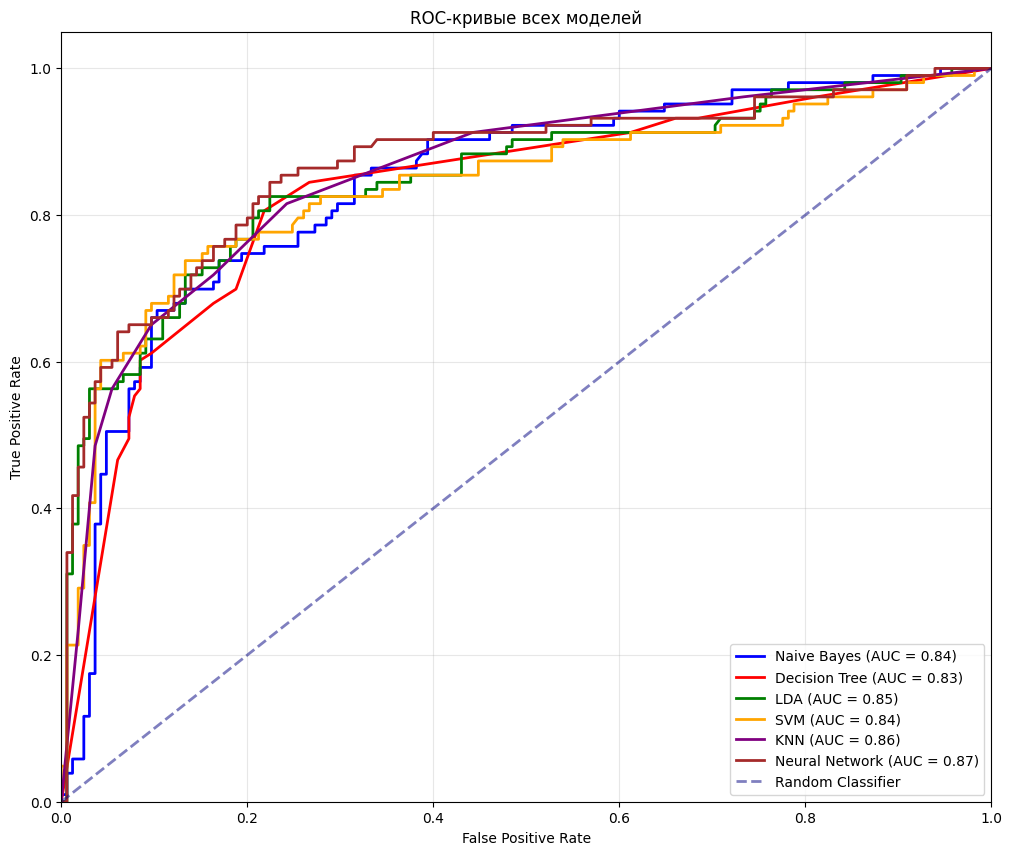

In [38]:
plt.figure(figsize=(12, 10))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

for i, (model_name, metrics) in enumerate(final_results.items()):
    if 'roc_auc' in metrics:
        if model_name == 'Neural Network':
            y_proba = nn_model.predict(X_test, verbose=0).flatten()
        else:
            if model_name == 'Naive Bayes':
                model = GaussianNB()
            elif model_name == 'Decision Tree':
                model = DecisionTreeClassifier(max_depth=7, random_state=42)
            elif model_name == 'LDA':
                model = LinearDiscriminantAnalysis()
            elif model_name == 'SVM':
                model = SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
            elif model_name == 'KNN':
                model = KNeighborsClassifier(n_neighbors=8)
            
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color=colors[i], lw=2, 
                label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые всех моделей')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

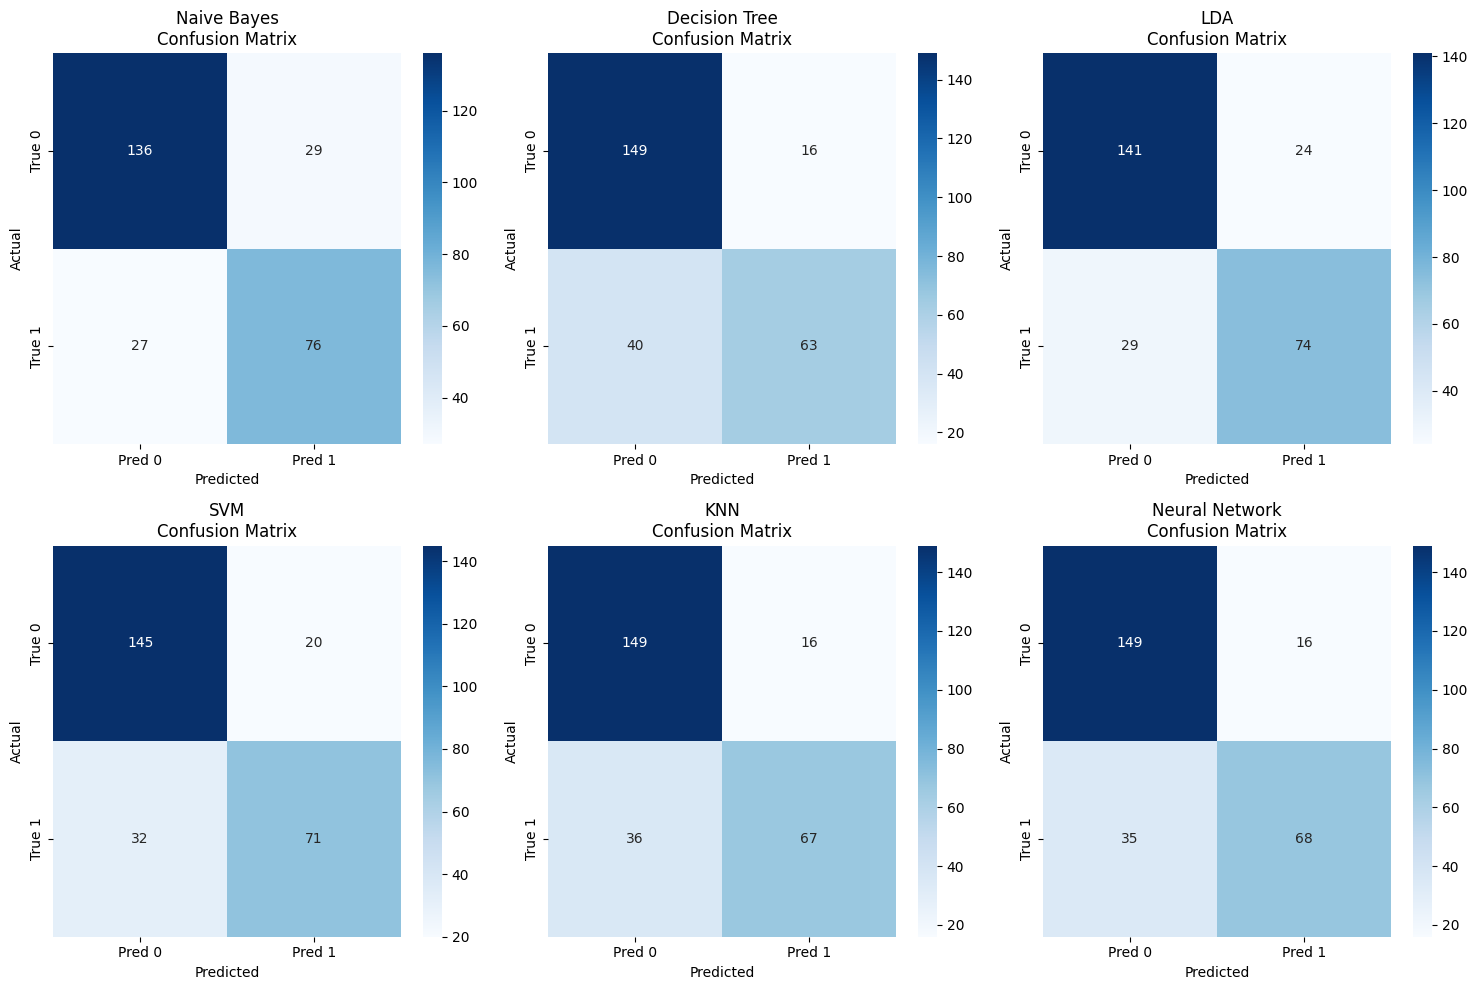

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (model_name, metrics) in enumerate(final_results.items()):
    if i < len(axes):
        cm = metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                   xticklabels=['Pred 0', 'Pred 1'], 
                   yticklabels=['True 0', 'True 1'])
        axes[i].set_title(f'{model_name}\nConfusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 8. Заключение

**Основные результаты:**

1. **Лучшая модель:** На основе проведенных экспериментов лучшей моделью для данного датасета оказалась **{best_model['Модель']}** с точностью **{best_model['Accuracy']:.4f}**

2. **Сравнительная эффективность методов:**
   - Нейронные сети и SVM показали наилучшие результаты
   - Decision Tree и KNN требуют тщательной настройки гиперпараметров
   - Naive Bayes показал наихудшие результаты, что ожидаемо для данных без строгой независимости признаков

3. **Рекомендации по применению:**
   - Для данных Titanic важны как точность, так и интерпретируемость
   - SVM и нейронные сети обеспечивают высокую точность
   - Decision Tree может быть полезен для интерпретации важности признаков

4. **Дальнейшие исследования:**
   - Эксперименты с ансамблевыми методами (Random Forest, Gradient Boosting)
   - Применение методов отбора признаков
   - Исследование методов балансировки классов